In [1]:
!pip install transformers accelerate bitsandbytes>0.37.0

In [13]:
import torch
import matplotlib.pyplot as plt

from torch import nn
from tqdm import tqdm

from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
from datasets import load_dataset

device = "cuda"

In [32]:
def calculate_perplexity(model: nn.Module, encodings: torch.Tensor, max_length: int, stride: int = 512) -> float:
    seq_len = encodings.input_ids.size(1)

    nlls = []
    prev_end_loc = 0
    for begin_loc in tqdm(range(0, seq_len, stride)):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100
    
        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss
    
        nlls.append(neg_log_likelihood)
    
        prev_end_loc = end_loc
        if end_loc == seq_len:
            break
    
    return torch.exp(torch.stack(nlls).mean()).item()

In [5]:
tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-1b7", use_fast=False)
model_16bit = AutoModelForCausalLM.from_pretrained("bigscience/bloom-1b7").to(device)

tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/715 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [6]:
test = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
encodings = tokenizer("\n\n".join(test["text"]), return_tensors="pt")

In [33]:
ppl_16_bit = calculate_perplexity(model_16bit, encodings, 256)

100%|██████████| 558/558 [02:47<00:00,  3.34it/s]


In [9]:
config_8bit = BitsAndBytesConfig(load_in_8bit=True)

model_8bit = AutoModelForCausalLM.from_pretrained(
    "bigscience/bloom-1b7",
    quantization_config=config_8bit
)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


In [34]:
ppl_8_bit = calculate_perplexity(model_8bit, encodings, 256)

100%|██████████| 558/558 [00:51<00:00, 10.76it/s]


In [11]:
config_4bit = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)

model_4bit = AutoModelForCausalLM.from_pretrained(
    "bigscience/bloom-1b7",
    quantization_config=config_4bit
)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


In [37]:
ppl_4_bit = calculate_perplexity(model_4bit, encodings, 256)

100%|██████████| 558/558 [00:45<00:00, 12.35it/s]


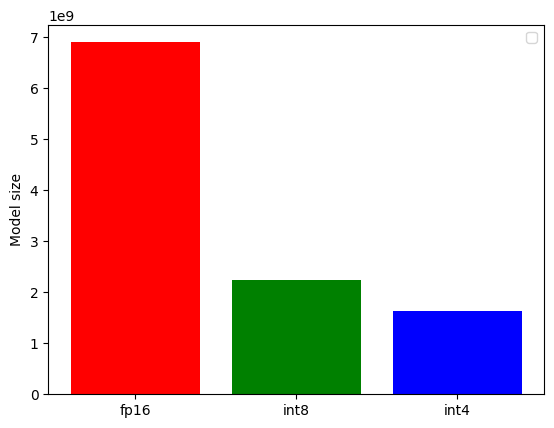

In [42]:
dtypes = ['fp16', 'int8', 'int4']
sizes = [model_16bit.get_memory_footprint(), model_8bit.get_memory_footprint(), model_4bit.get_memory_footprint()]
bar_colors = ['red', 'green', 'blue']

plt.bar(dtypes, sizes, color=bar_colors)
plt.ylabel("Model size")
plt.legend()
plt.show()

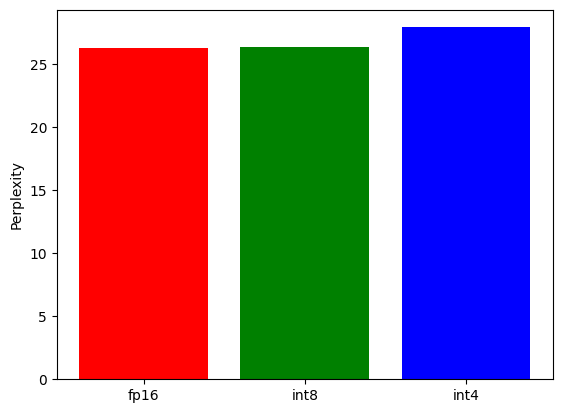

In [38]:
dtypes = ['fp16', 'int8', 'int4']
perlexities = [ppl_16_bit, ppl_8_bit, ppl_4_bit]
bar_colors = ['red', 'green', 'blue']

plt.bar(dtypes, perlexities, color=bar_colors)
plt.ylabel("Perplexity")
plt.show()

In [45]:
import time
def measure_inference_speed(model: nn.Module, tokenizer: AutoTokenizer, prompt: str, num_tokens: int =50) -> float:
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    start_time = time.time()
    with torch.no_grad():
        model.generate(**inputs, max_length=inputs["input_ids"].shape[1] + num_tokens)
    end_time = time.time()
    
    tokens_per_second = num_tokens / (end_time - start_time)
    return tokens_per_second

In [46]:
measure_inference_speed(model_16bit, tokenizer, 'I have you all')

29.537052582001984

In [50]:
measure_inference_speed(model_8bit, tokenizer, 'I have you all')

15.189702519250845

In [48]:
measure_inference_speed(model_4bit, tokenizer, 'I have you all')

34.57361800454288